# Sentiment analysis using Airbyte Cloud, Google sheets, and Snowflake Cortex



## Setup Airbyte Source as Google Sheets



*   Login to your airbyte cloud account and Select Google sheets as source
*   Provide the service account json and Spreadsheet link as per the airbyte documentation mentioned [here](https://docs.airbyte.com/integrations/sources/google-sheets#set-up-the-google-sheets-source-connector-in-airbyte)



### Setup Source - Google sheets Airbyte Cloud Screenshot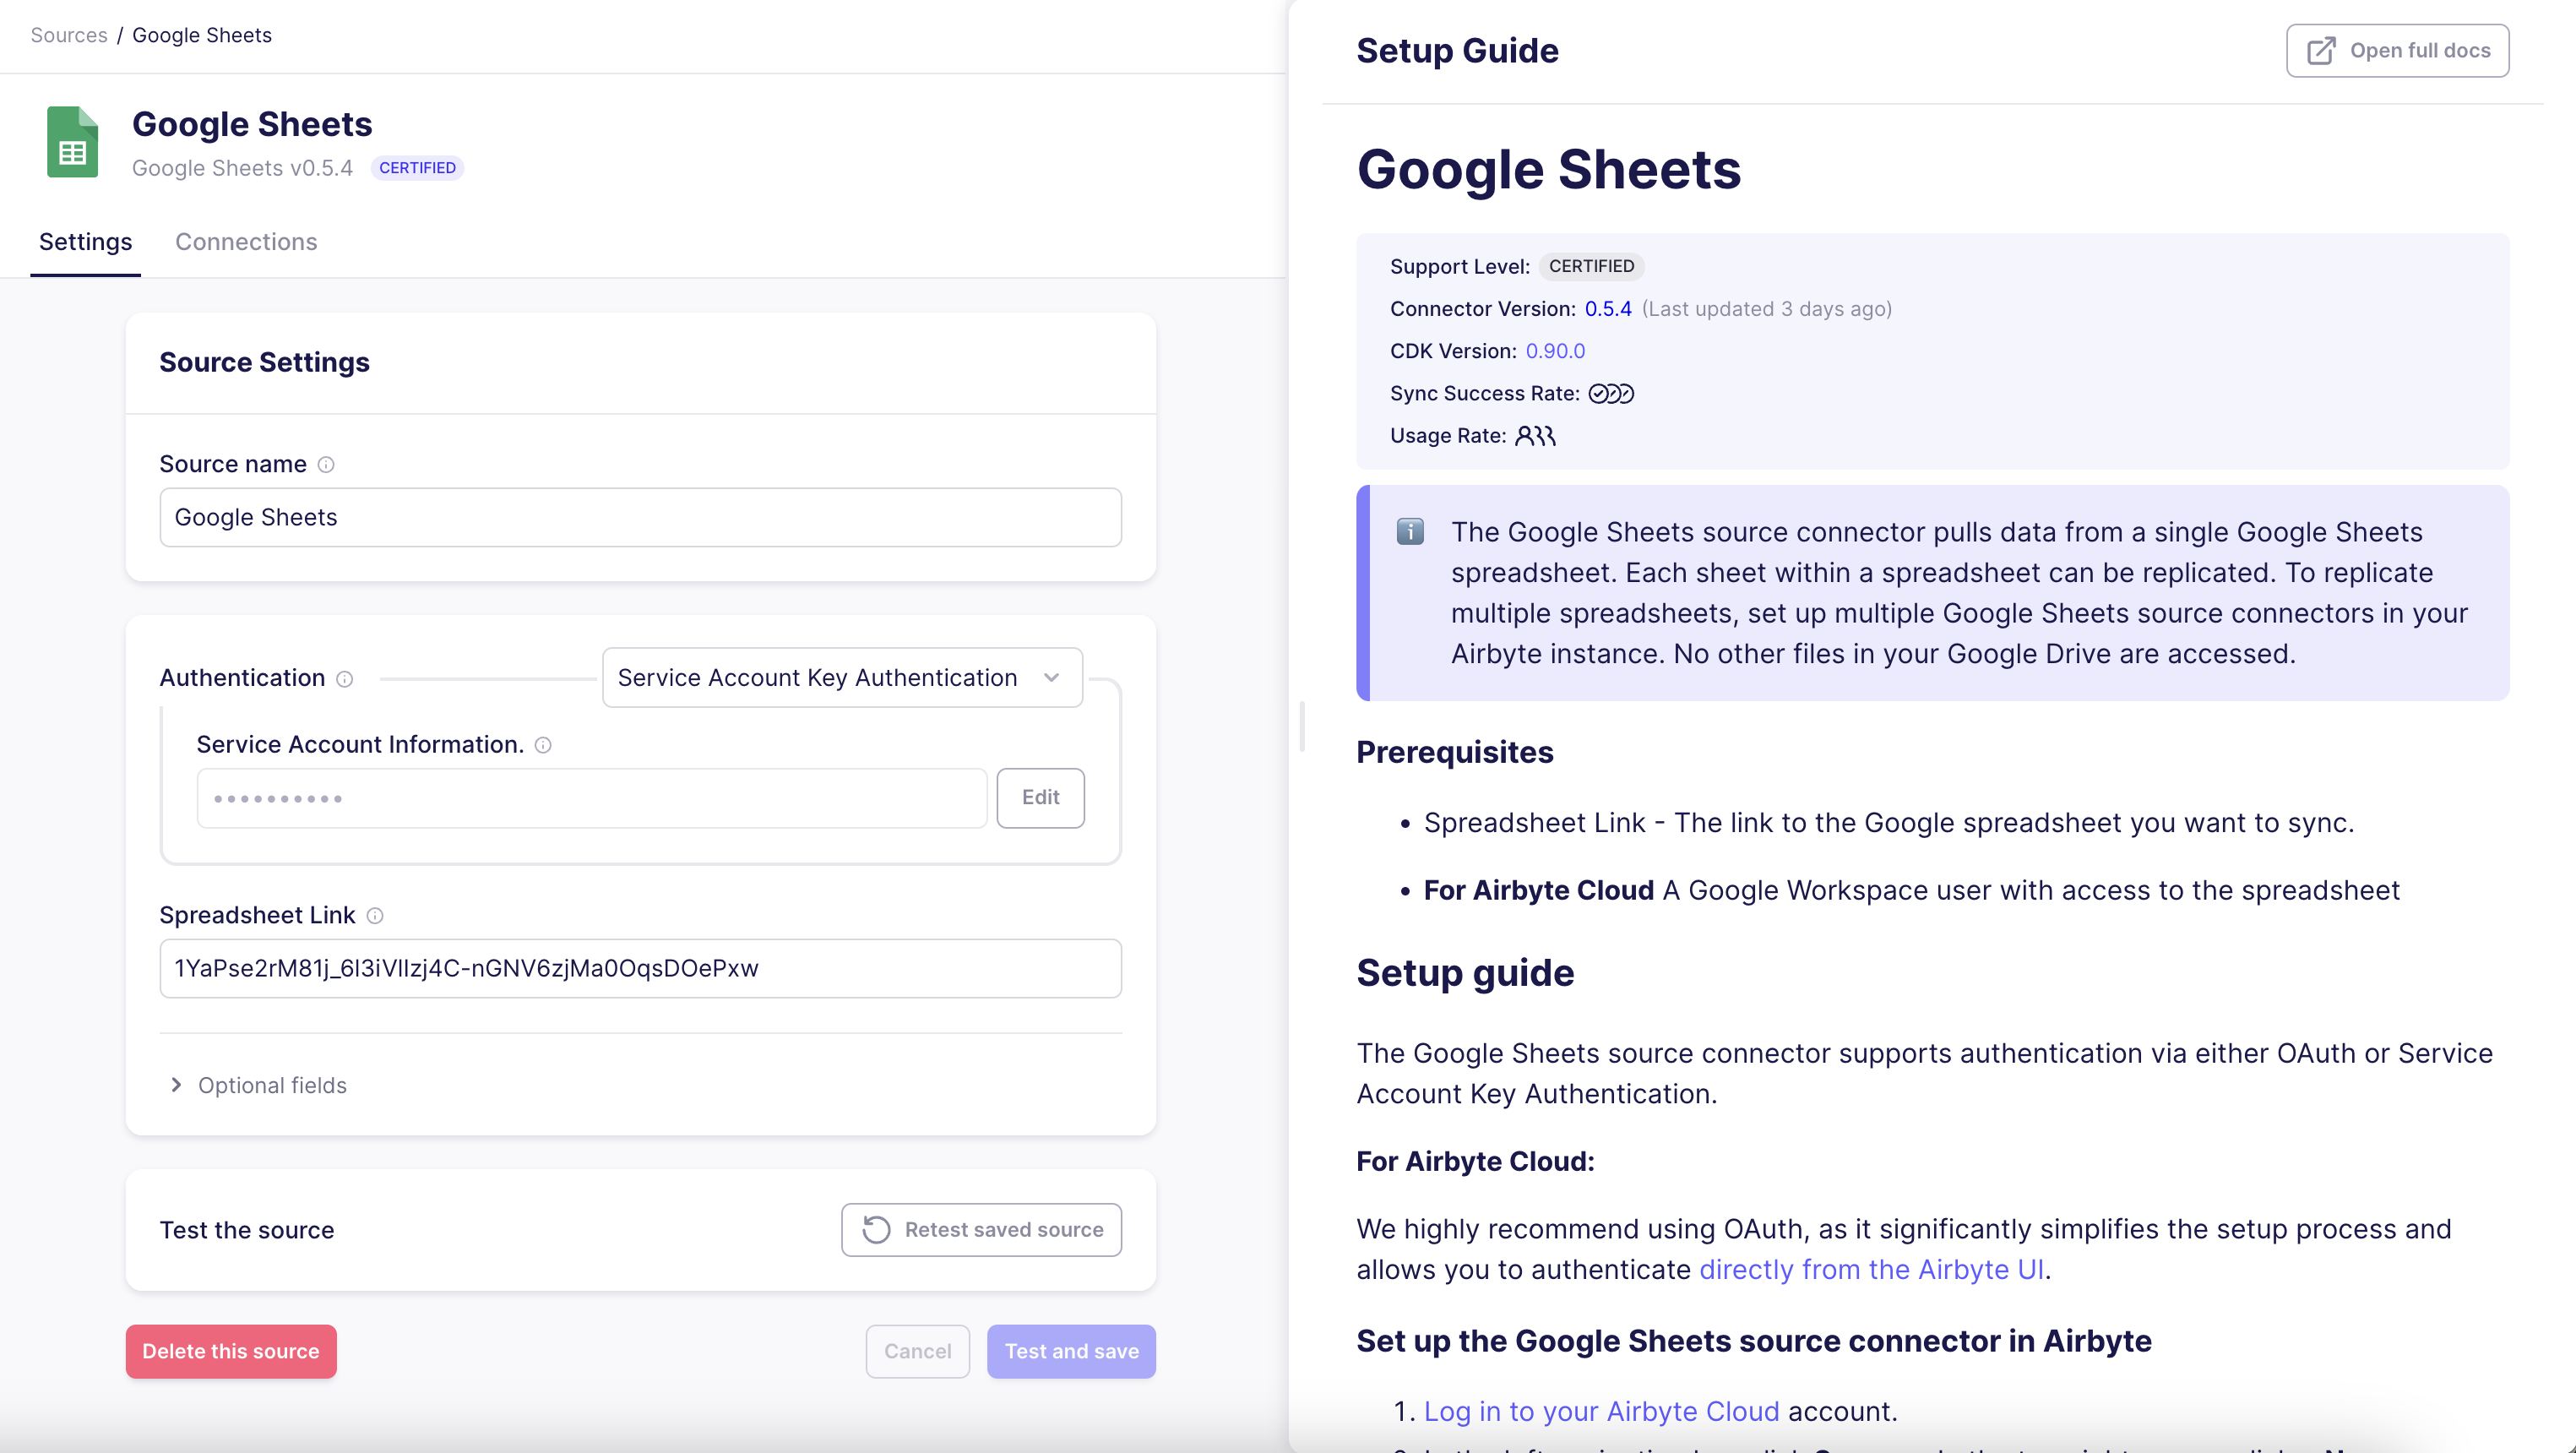

## Setup Airbyte Destination as Snowflake Cortex


*   Login to your airbyte cloud account and Select Snowflake Cortex as destination
*   Provide the required credentials per the airbyte documentation mentioned [here](https://docs.airbyte.com/integrations/destinations/snowflake-cortex#prerequisites)


## Setup Destination - Snowflake Cortex Airbyte Cloud Screenshot
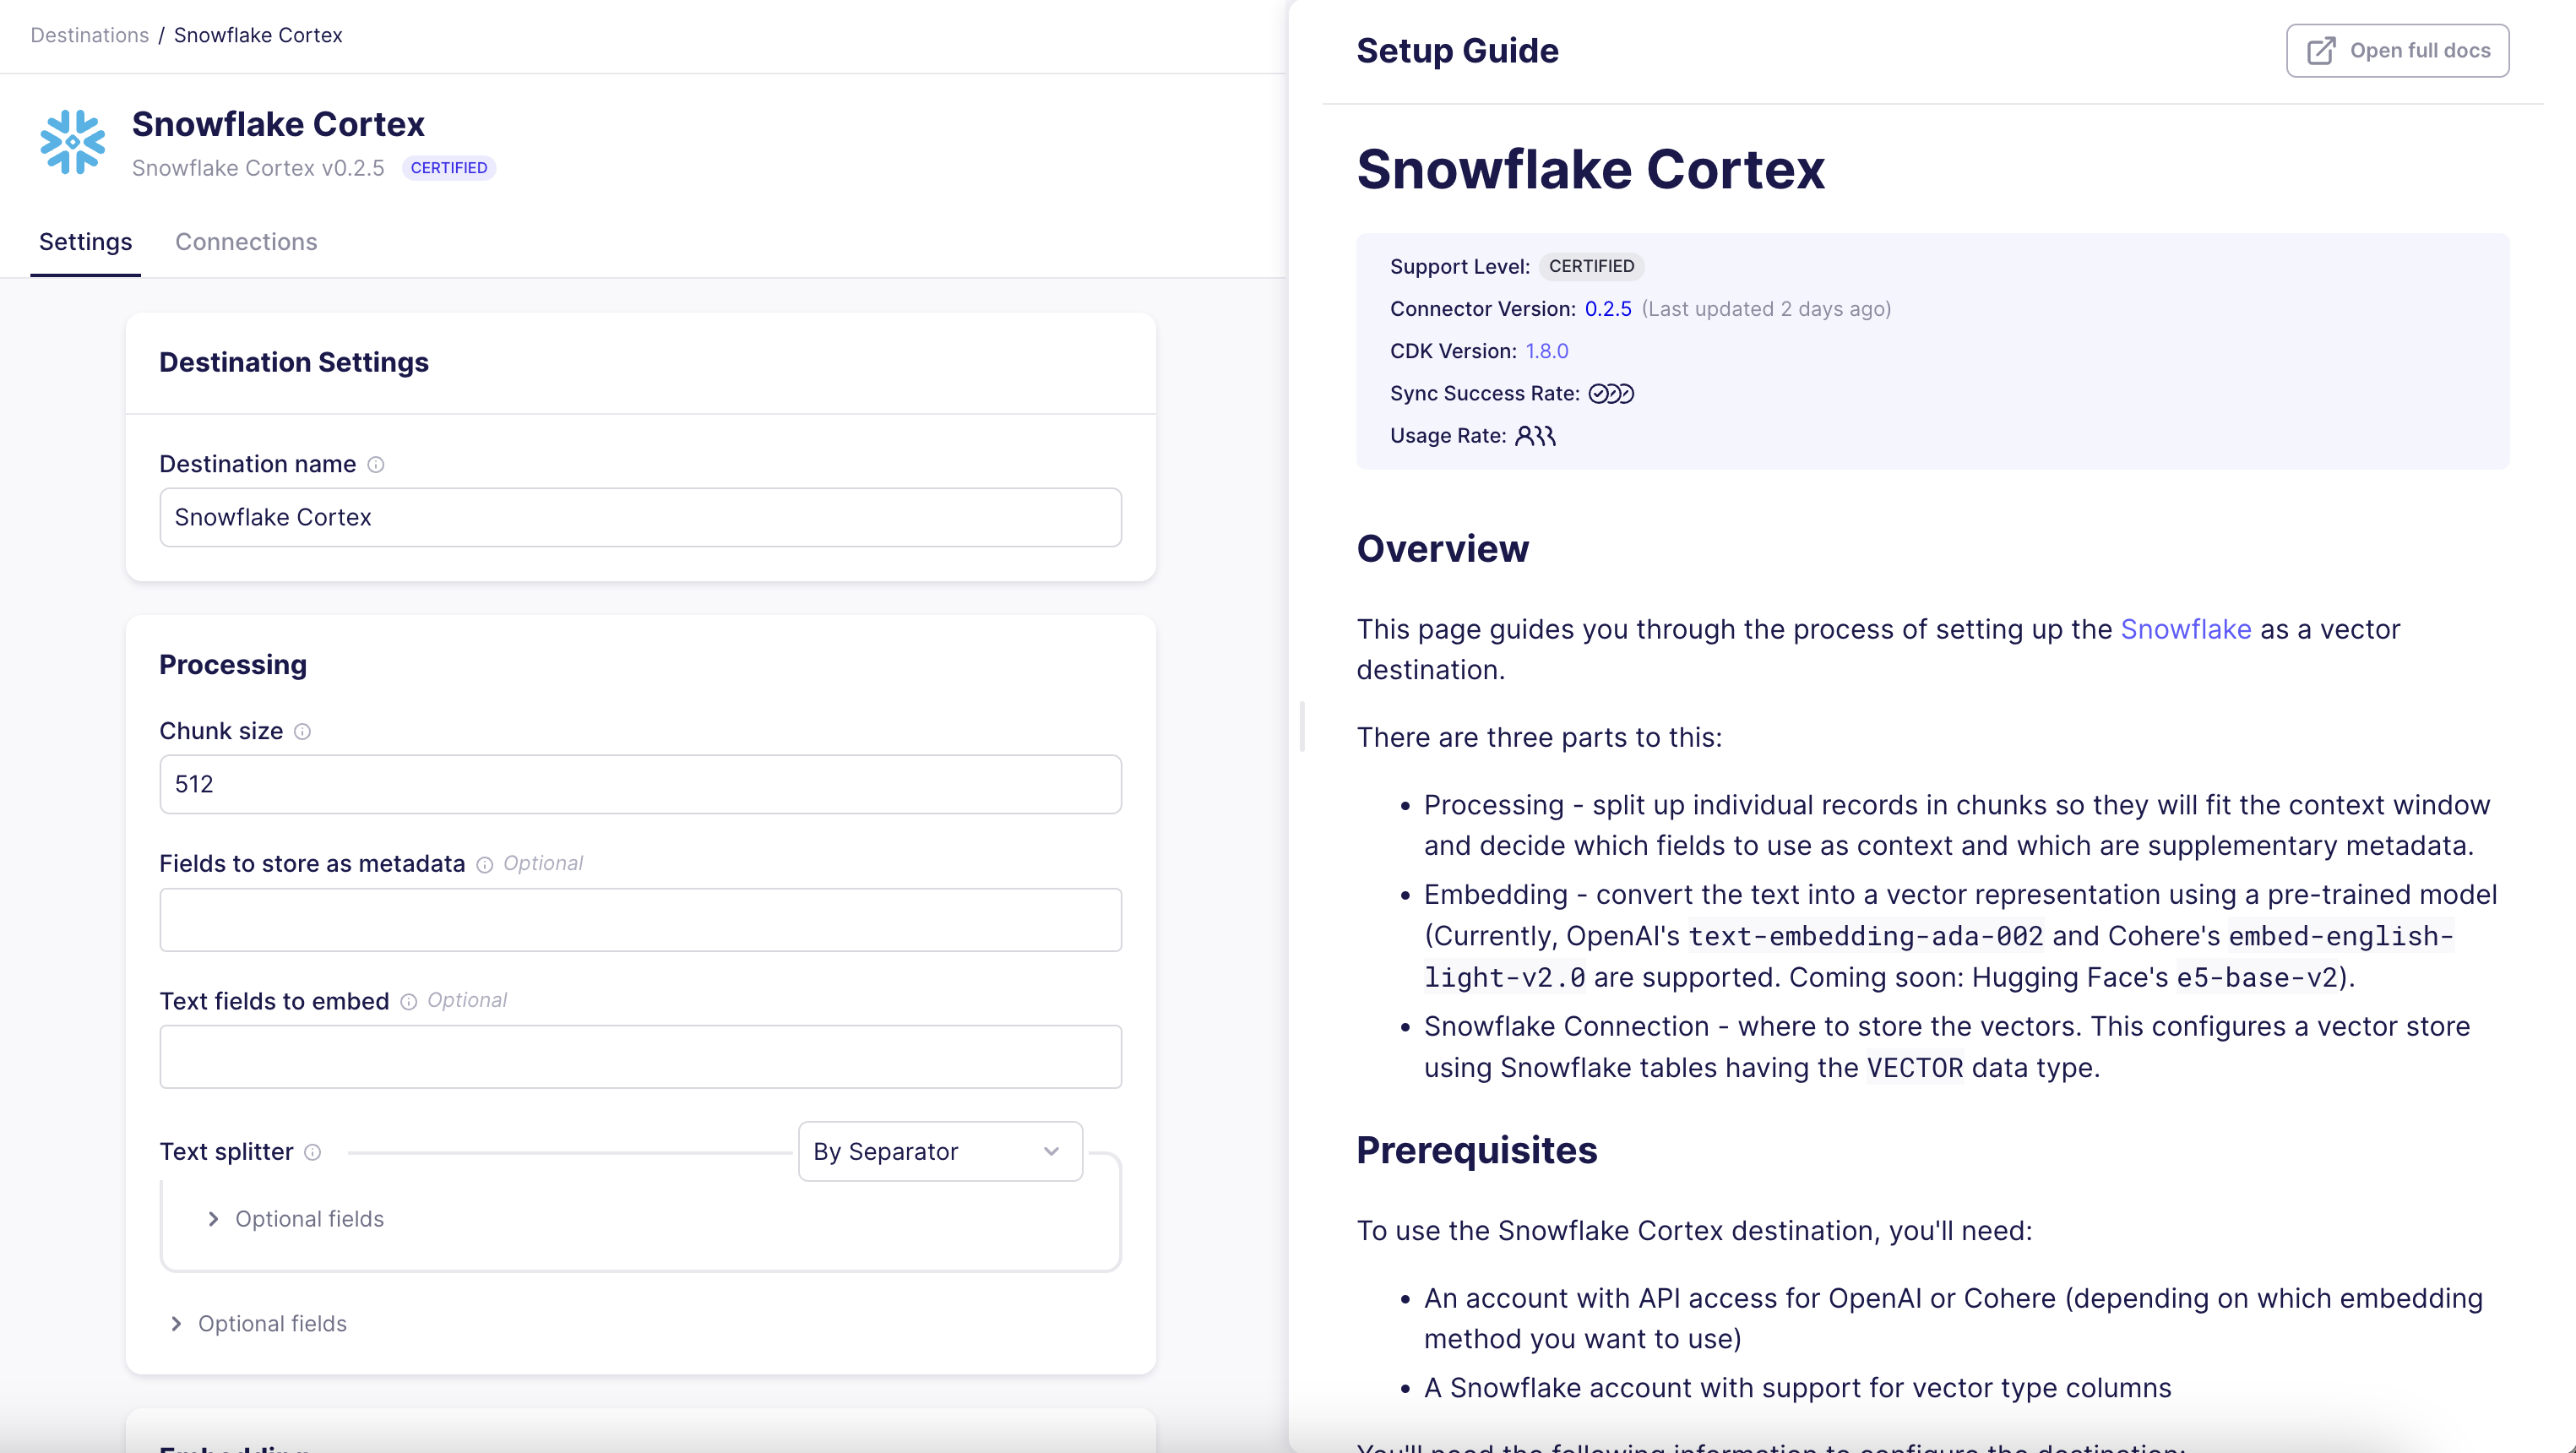



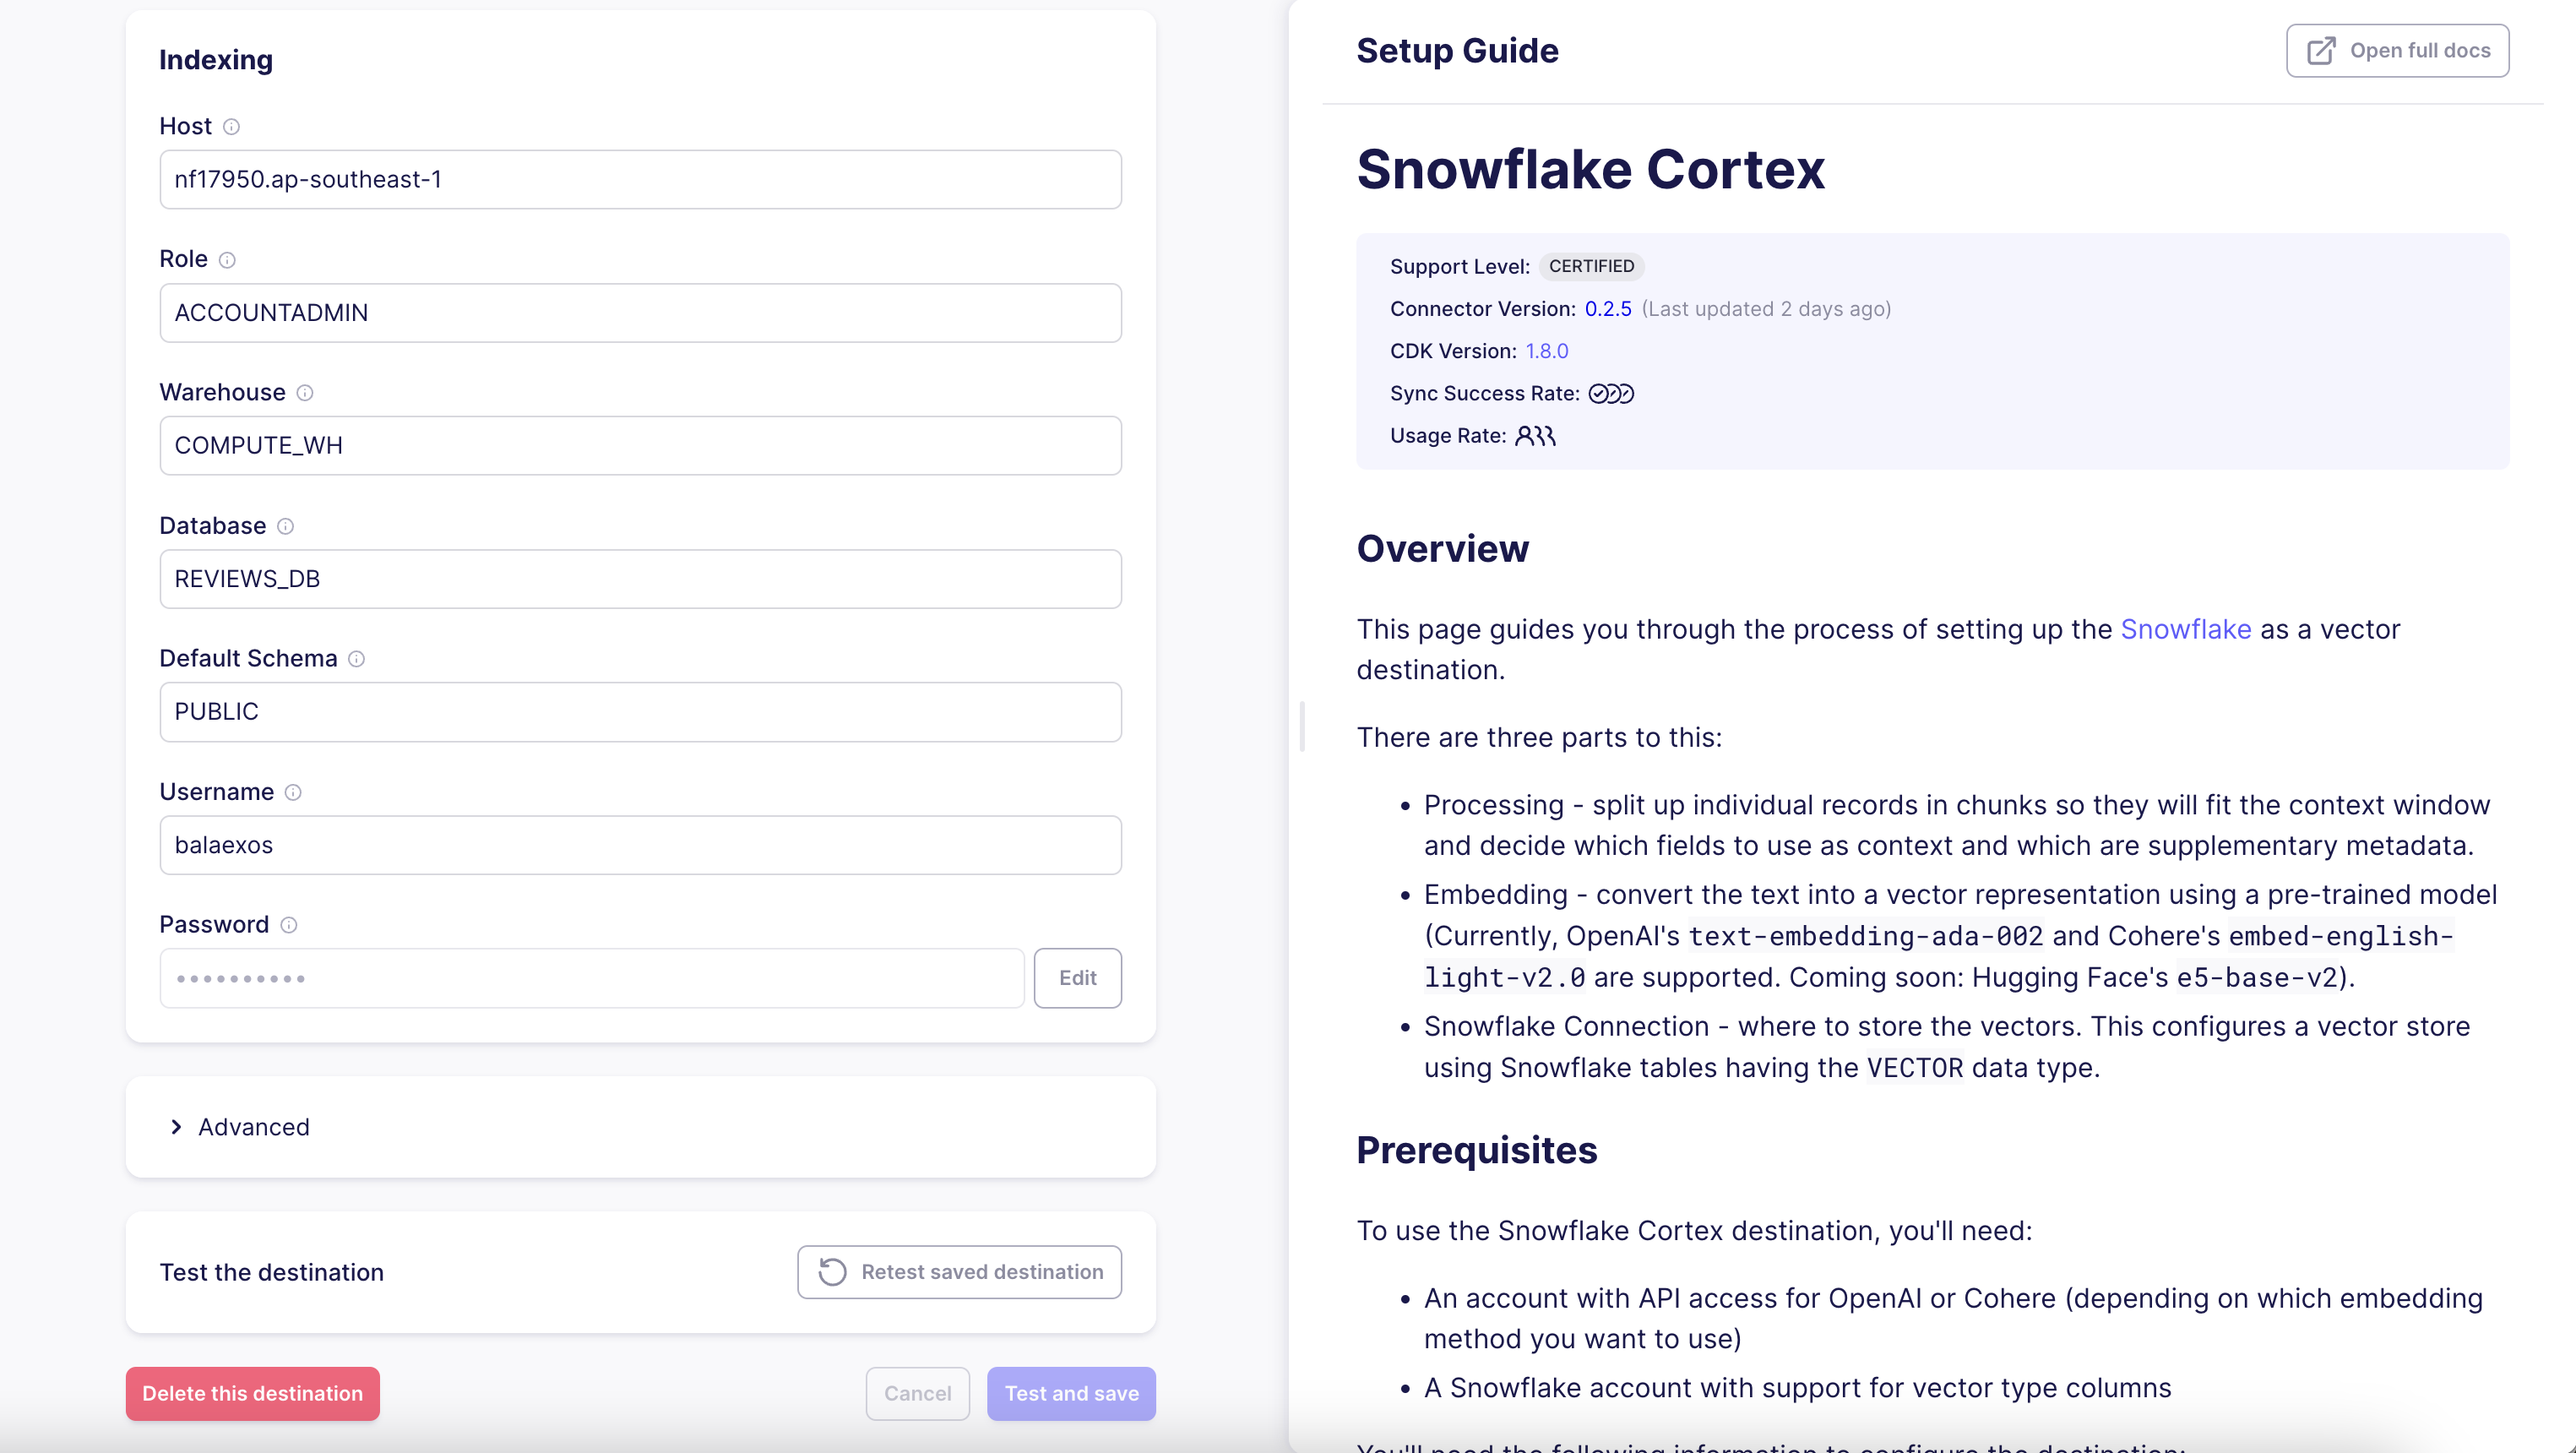

## Setting up the connector

Setup the connection between Airbyte Google Sheets source and Snowflake Cortex destination




## Install PyAirbyte and other dependencies

In [ ]:
!pip3 install airbyte openai langchain-openai snowflake-connector-python langchain_core

## Query the Records from Snowflake Cortex Airbyte Destination

In [2]:
from snowflake import connector
from google.colab import userdata
from typing import List
import pandas as pd

def get_db_connection():
    return connector.connect(
        account=userdata.get("SNOWFLAKE_HOST"),
        role=userdata.get("SNOWFLAKE_ROLE"),
        warehouse=userdata.get("SNOWFLAKE_WAREHOUSE"),
        database=userdata.get("SNOWFLAKE_DATABASE"),
        schema=userdata.get("SNOWFLAKE_SCHEMA"),
        user=userdata.get("SNOWFLAKE_USERNAME"),
        password=userdata.get("SNOWFLAKE_PASSWORD"),
    )

def fetch_table_data(table_name, columns):
    conn = get_db_connection()
    cursor = conn.cursor()

    # Construct the query
    columns_str = ", ".join(columns)
    query = f"SELECT {columns_str} FROM {table_name} LIMIT 5;"

    cursor.execute(query)
    result = cursor.fetchall()

    # Get column names
    col_names = [desc[0] for desc in cursor.description]

    cursor.close()
    conn.close()

    # Convert the result to a pandas DataFrame
    df = pd.DataFrame(result, columns=col_names)
    return df;



data_frame = fetch_table_data("AMAZON_REVIEWS", ["DOCUMENT_ID","DOCUMENT_CONTENT"])
data_frame



,DOCUMENT_ID,DOCUMENT_CONTENT
0,147706135155296294706750175152529247047,"""reviewerName: 0mie\noverall: 5\nreviewText: P..."
1,310610605518759482714931752273988313361,"""reviewerName: 1K3\noverall: 4\nreviewText: it..."
2,321811899600750519985540060710072527880,"""reviewerName: 1m2\noverall: 5\nreviewText: Th..."
3,161308189025596278679660362756706325714,"""reviewerName: 2&amp;1/2Men\noverall: 5\nrevie..."
4,320500296319786972506727202798756081031,"""reviewerName: 2Cents!\noverall: 5\nreviewText..."


## Run Sentiment analysis from Snowflake Cortex Airbyte Destination Records

In [5]:
from snowflake import connector
from IPython.display import display, HTML

def get_db_connection():
    return connector.connect(
        account=userdata.get("SNOWFLAKE_HOST"),
        role=userdata.get("SNOWFLAKE_ROLE"),
        warehouse=userdata.get("SNOWFLAKE_WAREHOUSE"),
        database=userdata.get("SNOWFLAKE_DATABASE"),
        schema=userdata.get("SNOWFLAKE_SCHEMA"),
        user=userdata.get("SNOWFLAKE_USERNAME"),
        password=userdata.get("SNOWFLAKE_PASSWORD"),
    )


def get_sentiment_analysis_from_snowflake(table_name):
        conn = get_db_connection()
        cur = conn.cursor()


        query = f"""
            SELECT
                DOCUMENT_CONTENT,
                CASE
                    WHEN SENTIMENT_SCORE > 0 THEN 'Positive'
                    WHEN SENTIMENT_SCORE < 0 THEN 'Negative'
                    ELSE 'Neutral'
                END AS SENTIMENT
            FROM (
                SELECT
                    SNOWFLAKE.CORTEX.SENTIMENT(DOCUMENT_CONTENT) AS SENTIMENT_SCORE,
                    DOCUMENT_CONTENT
                FROM {table_name}
                LIMIT 5
            );
        """
        cur.execute(query)
        result = cur.fetchall()
        col_names = [desc[0] for desc in cur.description]

        df = pd.DataFrame(result,columns=col_names)

        return df




response = get_sentiment_analysis_from_snowflake("amazon_reviews")

display(HTML(response.to_html(index=False)))

DOCUMENT_CONTENT,SENTIMENT
"""reviewerName: 0mie\noverall: 5\nreviewText: Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.\nreviewTime: 2013-10-25\nday_diff: 409\nhelpful_yes: 0\nhelpful_no: 0\ntotal_vote: 0\nscore_pos_neg_diff: 0\nscore_average_rating: 0\nwilson_lower_bound: 0""",Negative
"""reviewerName: 1K3\noverall: 4\nreviewText: it works as expected. I should have sprung for the higher capacity. I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before\nreviewTime: 2012-12-23\nday_diff: 715\nhelpful_yes: 0\nhelpful_no: 0\ntotal_vote: 0\nscore_pos_neg_diff: 0\nscore_average_rating: 0\nwilson_lower_bound: 0""",Negative
"""reviewerName: 1m2\noverall: 5\nreviewText: This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!\nreviewTime: 2013-11-21\nday_diff: 382\nhelpful_yes: 0\nhelpful_no: 0\ntotal_vote: 0\nscore_pos_neg_diff: 0\nscore_average_rating: 0\nwilson_lower_bound: 0""",Positive
"""reviewerName: 2&amp;1/2Men\noverall: 5\nreviewText: Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card\nreviewTime: 2013-07-13\nday_diff: 513\nhelpful_yes: 0\nhelpful_no: 0\ntotal_vote: 0\nscore_pos_neg_diff: 0\nscore_average_rating: 0\nwilson_lower_bound: 0""",Negative
"""reviewerName: 2Cents!\noverall: 5\nreviewText: It's mini storage. It doesn't do anything else and it's not supposed to. I purchased it to add additional storage to my Microsoft Surface Pro tablet which only come in 64 and 128 GB. It does what it's supposed to and SanDisk has a long standing reputation that speaks for itself.\nreviewTime: 2013-04-29\nday_diff: 588\nhelpful_yes: 0\nhelpful_no: 0\ntotal_vote: 0\nscore_pos_neg_diff: 0\nscore_average_rating: 0\nwilson_lower_bound: 0""",Negative
